In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from helper_functions import sample_data_with_optional_balancing

In [16]:
data= r"G:\SP8_FLIM\sMol_experiment\Avcute\Outputs\master_table2.csv"
data2=r"G:\SP8_FLIM\sMol_experiment\CAD\Outputs\master_table.csv"
df= pd.read_csv(data)#,sep=",")
df2= pd.read_csv(data2)#,sep=",")

In [19]:
# Concatenate the DataFrames
combined_df = pd.concat([df, df2], ignore_index=True)

# Optional: Check the combined DataFrame
print(combined_df.head())

# Save the combined DataFrame if needed
output_path = r"G:\SP8_FLIM\sMol_experiment\Avcute\Outputs\combined_master_table.csv"
combined_df.to_csv(output_path, index=False)

print(f"Combined DataFrame saved to {output_path}")

   Unnamed: 0  Label   Area  intensity_mean_fluor   mean_chi2     mean_tau  \
0           0    1.0   44.0            631.250000  108.636364  1081.545455   
1           1    2.0   33.0            759.272727  113.484848  1027.333333   
2           2    3.0  105.0            960.971429  118.647619  1229.076190   
3           3    4.0  128.0            527.328125  108.406250  1238.968750   
4           4    5.0   60.0            618.983333  112.600000  1312.683333   

   min_fluor  min_chi2  min_tau   STD_fluor   STD_chi2     STD_tau File Name  \
0      572.0      84.0    846.0   33.568197  13.790792  134.898186        1f   
1      684.0      89.0    852.0   52.277391  14.114513   80.425259        1f   
2      712.0      89.0    920.0  107.885871  11.714851  105.571704        1f   
3      403.0      72.0    800.0   55.671765  11.533536  136.863638        1f   
4      460.0      88.0    968.0   89.290255  12.068140  129.563690        1f   

  cells transfection       treatment        Date  

In [20]:
# # Reassign the result back to the 'treatment' column
# df['treatment'] = df['treatment'].replace(['nt', 'prop', '5htp'], ['NT', 'pro', '5HTP100'])

# Now check the unique conditions
unique_conditions = combined_df['treatment'].unique()
print(unique_conditions)
# # Save the DataFrame back to CSV with the new column
# output_path = r"G:\SP8_FLIM\sMol_experiment\CAD\Outputs\master_table_renamed.csv"
# df.to_csv(output_path, index=False)'

['fluox-Acute100' 'imi-Acute100' 'pro-Acute100' 'CQ-Acute100' 'cq' 'dmso'
 'fluox' 'imi' 'pro' 'res' 'prop' 'nt' '5htp' '5HTP100' 'ldopa' 'NT']


In [6]:
def sample_data_with_optional_balancing(data, n=100, balance_by_date=False, group_columns=None):
    import numpy as np
    import pandas as pd

    """
    Sample `n` instances for each combination of specified grouping columns.
    Optionally balance the sampling by `Date` if `balance_by_date` is True. Logs cases where
    fewer than `n` instances are available.

    Args:
    - data: DataFrame containing the data to sample from.
    - n: Number of instances to sample for each group combination.
    - balance_by_date: Boolean flag indicating whether to balance samples by `Date` (default: False).
    - group_columns: List of column names to group by (default: ['transfection', 'cells', 'treatment']).

    Returns:
    - A tuple: (sampled_data, shortfall_log)
      sampled_data: A DataFrame with the sampled data.
      shortfall_log: A DataFrame logging groups where fewer than `n` instances were available.
    """
    
    if group_columns is None:
        group_columns = ['transfection', 'cells', 'treatment']

    # Group the data by the specified columns
    grouped_data = data.groupby(group_columns)

    sampled_data = pd.DataFrame()
    shortfall_log = []

    # Iterate over each group
    for group_name, group_df in grouped_data:
        total_available = len(group_df)

        # If the group has fewer than `n` instances, log the shortfall
        if total_available < n:
            shortfall_log.append({
                'group': group_name,
                'available_instances': total_available,
                'requested_samples': n
            })
            sampled_group_df = group_df
        else:
            group_df = group_df.sample(frac=1, random_state=42)

            if balance_by_date and 'Date' in group_df.columns:
                date_counts = group_df['Date'].value_counts()
                samples_per_date = (date_counts / date_counts.sum() * n).astype(int)
                sampled_group_df = pd.DataFrame()

                for date, count in samples_per_date.items():
                    available_from_date = len(group_df[group_df['Date'] == date])
                    samples_to_take = min(count, available_from_date)
                    sampled_group_df = pd.concat([
                        sampled_group_df,
                        group_df[group_df['Date'] == date].sample(samples_to_take, replace=False)
                    ])

                if len(sampled_group_df) < n:
                    additional_samples = group_df[~group_df.index.isin(sampled_group_df.index)].sample(n - len(sampled_group_df), replace=False)
                    sampled_group_df = pd.concat([sampled_group_df, additional_samples])
                elif len(sampled_group_df) > n:
                    sampled_group_df = sampled_group_df.sample(n=n, replace=False)
            else:
                sampled_group_df = group_df.sample(n=n, replace=False, random_state=42)

        sampled_data = pd.concat([sampled_data, sampled_group_df], ignore_index=True)

    # Convert the shortfall log to a DataFrame
    shortfall_log_df = pd.DataFrame(shortfall_log)

    if not shortfall_log_df.empty:
        print("Groups with fewer available instances than requested:")
        print(shortfall_log_df)
    else:
        print("No shortfalls found!")

    return sampled_data, shortfall_log_df


In [7]:
# Define your desired grouping columns
group_columns = ['cells', 'treatment', 'typeoftreatment']

# Call the updated function with the new grouping columns
sampled_data, shortfall_log = sample_data_with_optional_balancing(
    data=df,
    n=100,
    balance_by_date=False,
    group_columns=group_columns
)


No shortfalls found!


In [8]:
sampled_data

,Unnamed: 0,Label,Area,intensity_mean_fluor,mean_chi2,mean_tau,min_fluor,min_chi2,min_tau,STD_fluor,STD_chi2,STD_tau,File Name,cells,typeoftreatment,treatment,Date,selected_analysis
0,22,23,140.0,651.414286,109.421429,1248.857143,434.0,78.0,818.0,125.492287,12.539690,139.354716,3f,cl1,Acute100,CQ,2024-08-11,analyze_single_fitted_channel
1,22,23,32.0,582.875000,111.156250,1429.281250,519.0,90.0,1108.0,28.964148,12.036687,139.374548,2f,cl1,Acute100,CQ,2024-08-11,analyze_single_fitted_channel
2,11,12,125.0,695.760000,114.096000,1444.184000,589.0,84.0,1039.0,52.939120,12.639889,153.460999,2f,cl1,Acute100,CQ,2024-08-11,analyze_single_fitted_channel
3,69,70,67.0,910.014925,115.164179,1170.044776,626.0,86.0,938.0,114.536508,13.266046,88.251918,1f,cl1,Acute100,CQ,2024-08-11,analyze_single_fitted_channel
4,73,74,45.0,471.177778,100.022222,1160.333333,444.0,78.0,890.0,17.757989,10.203461,139.953008,3f,cl1,Acute100,CQ,2024-08-11,analyze_single_fitted_channel
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,53,54,63.0,581.301587,102.698413,1249.888889,518.0,79.0,962.0,34.331084,11.210306,127.137360,2f,cl2,Acute100,pro,2024-08-11,analyze_single_fitted_channel
796,79,80,36.0,588.416667,104.777778,1142.000000,466.0,86.0,811.0,41.227940,9.784089,135.686526,2f,cl2,Acute100,pro,2024-08-11,analyze_single_fitted_channel
797,53,54,46.0,372.282609,95.630435,1176.239130,358.0,75.0,808.0,7.368154,9.796536,174.881971,4f,cl2,Acute100,pro,2024-08-11,analyze_single_fitted_channel
798,101,102,167.0,659.808383,105.257485,1032.976048,464.0,80.0,734.0,124.909497,11.843776,114.285804,2f,cl2,Acute100,pro,2024-08-11,analyze_single_fitted_channel


In [21]:
sampled_data, log = sample_data_with_optional_balancing(combined_df, n=150, balance_by_date=False)


Groups with fewer available instances than requested:
                         group  available_instances  requested_samples
0  (VMAT, cl2, fluox-Acute100)                  145                150
1            (vmat, cl1, 5htp)                  125                150


c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


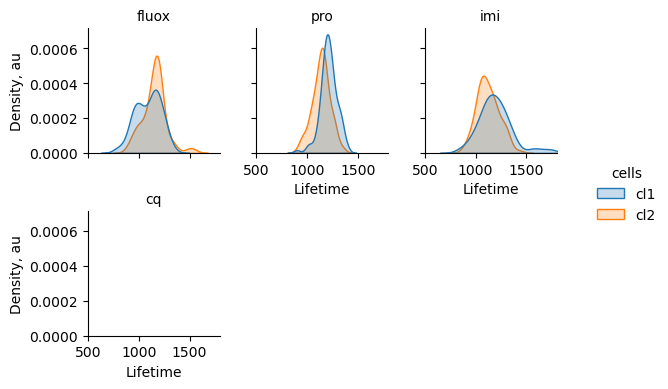

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Define the desired order of 'treatment' columns
treatment_order = ['fluox','pro','imi','cq']  # Adjust based on your actual treatments

# Check if there's data in the filtered datasets
#if not sampled_data_1.empty:
    # Plot for the first subset (e.g., CellType1)
h1 = sns.displot(
    sampled_data, hue="cells", x="mean_tau", col="treatment",col_order=treatment_order,
    kind="kde", height=2, aspect=1, fill=True, col_wrap=3, # Specify the order of the 'treatment' columns
    )
    # Set axis labels and titles for the first plot
h1.set_axis_labels("Lifetime", "Density, au")
h1.set_titles("{col_name}")
h1.set(xlim=(500, 1800))
#plt.suptitle("Density of Lifetime by Transfection and Treatment for CellType1", fontsize=16)
plt.show()




c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


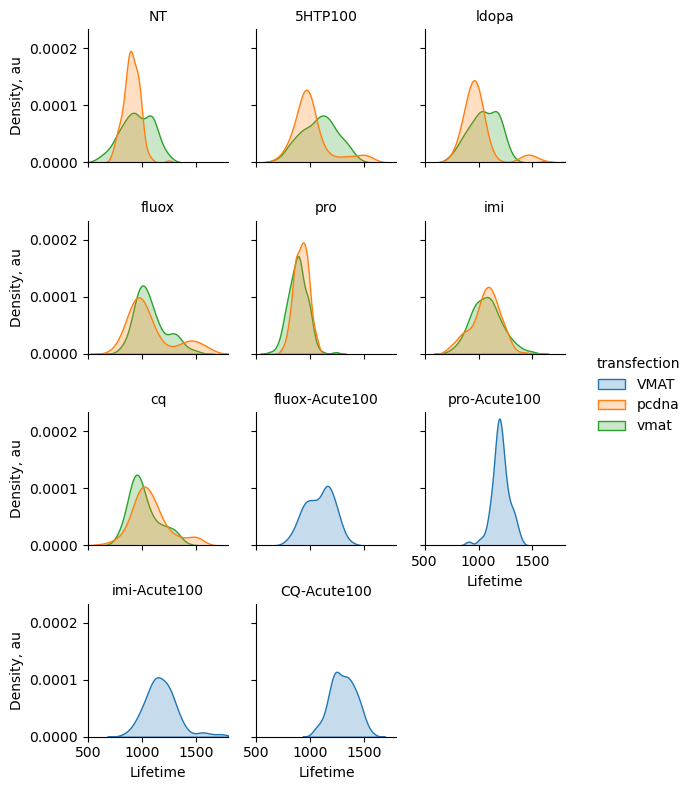

c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


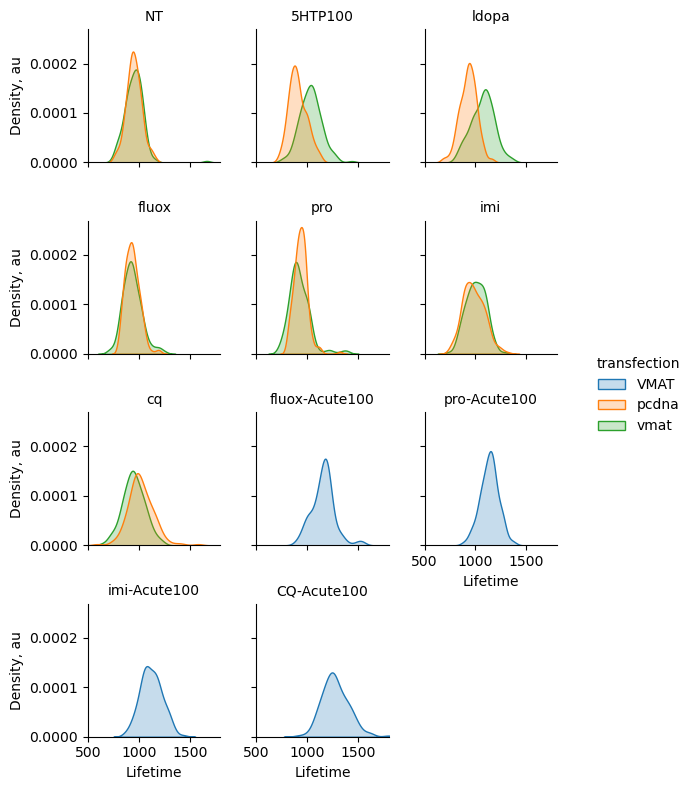

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for two different cell types
sampled_data_1 = sampled_data[sampled_data['cells'] == 'cl1']
sampled_data_2 = sampled_data[sampled_data['cells'] == 'cl2']

# Define the desired order of 'treatment' columns
treatment_order = ['NT', '5HTP100', 'ldopa','fluox','pro','imi','cq','fluox-Acute100', 'pro-Acute100','imi-Acute100', 'CQ-Acute100']  # Adjust based on your actual treatments

# Check if there's data in the filtered datasets
if not sampled_data_1.empty:
    # Plot for the first subset (e.g., CellType1)
    h1 = sns.displot(
        sampled_data_1, hue="transfection", x="mean_tau", col="treatment",
        kind="kde", height=2, aspect=1, fill=True, col_wrap=3,col_order=treatment_order  # Specify the order of the 'treatment' columns
    )
    # Set axis labels and titles for the first plot
    h1.set_axis_labels("Lifetime", "Density, au")
    h1.set_titles("{col_name}")
    h1.set(xlim=(500, 1800))
    #plt.suptitle("Density of Lifetime by Transfection and Treatment for CellType1", fontsize=16)
    plt.show()
else:
    print("No data available for CellType1")

# Check if there's data in the second filtered dataset
if not sampled_data_2.empty:
    # Plot for the second subset (e.g., CellType2)
    h2 = sns.displot(
        sampled_data_2, hue="transfection", x="mean_tau", col="treatment",
        kind="kde", height=2, aspect=1, fill=True, col_wrap=3,col_order=treatment_order  # Specify the order of the 'treatment' columns
    )
    # Set axis labels and titles for the second plot
    h2.set_axis_labels("Lifetime", "Density, au")
    h2.set_titles("{col_name}")
    h2.set(xlim=(500, 1800))
    #plt.suptitle("Density of Lifetime by Transfection and Treatment for CellType2", fontsize=16)
    plt.show()
else:
    print("No data available for CellType2")


Here end 

c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


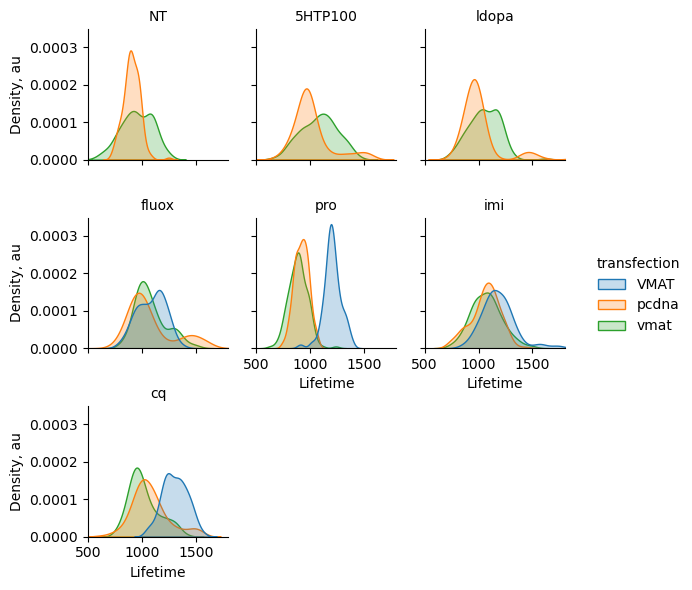

c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


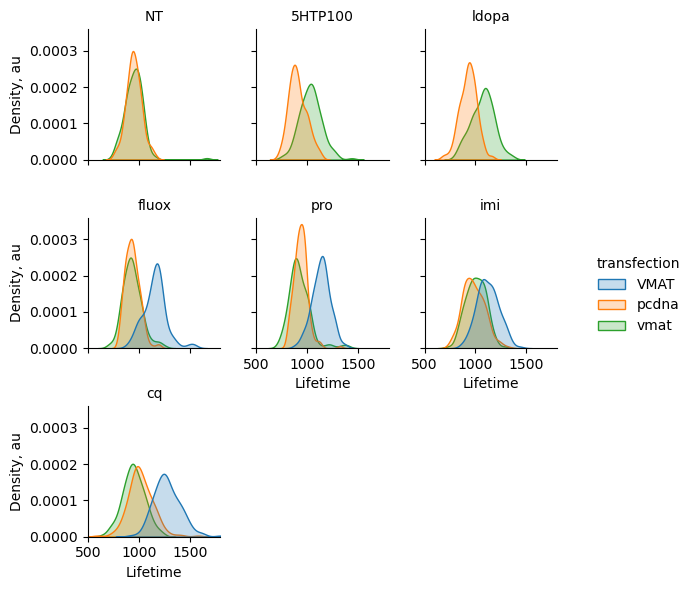

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define a mapping for grouping treatments
treatment_mapping = {
    'fluox': 'fluox',
    'fluox-Acute100': 'fluox',
    'pro': 'pro',
    'pro-Acute100': 'pro',
    'imi': 'imi',
    'imi-Acute100': 'imi',
    'cq': 'cq',
    'CQ-Acute100': 'cq',
    'NT': 'NT',
    '5HTP100': '5HTP100',
    'ldopa': 'ldopa'
}

# Apply the mapping to create a new column 'treatment_group'
sampled_data['treatment_group'] = sampled_data['treatment'].map(treatment_mapping)

# Define the desired order of 'treatment_group' columns
treatment_group_order = ['NT', '5HTP100', 'ldopa', 'fluox', 'pro', 'imi', 'cq']

# Filter for two different cell types
sampled_data_1 = sampled_data[sampled_data['cells'] == 'cl1']
sampled_data_2 = sampled_data[sampled_data['cells'] == 'cl2']

# Check if there's data in the filtered datasets
if not sampled_data_1.empty:
    # Plot for the first subset (e.g., CellType1)
    h1 = sns.displot(
        sampled_data_1, hue="transfection", x="mean_tau", col="treatment_group",
        kind="kde", height=2, aspect=1, fill=True, col_wrap=3, col_order=treatment_group_order
    )
    # Set axis labels and titles for the first plot
    h1.set_axis_labels("Lifetime", "Density, au")
    h1.set_titles("{col_name}")
    h1.set(xlim=(500, 1800))
    plt.show()
else:
    print("No data available for CellType1")

# Check if there's data in the second filtered dataset
if not sampled_data_2.empty:
    # Plot for the second subset (e.g., CellType2)
    h2 = sns.displot(
        sampled_data_2, hue="transfection", x="mean_tau", col="treatment_group",
        kind="kde", height=2, aspect=1, fill=True, col_wrap=3, col_order=treatment_group_order
    )
    # Set axis labels and titles for the second plot
    h2.set_axis_labels("Lifetime", "Density, au")
    h2.set_titles("{col_name}")
    h2.set(xlim=(500, 1800))
    plt.show()
else:
    print("No data available for CellType2")



c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


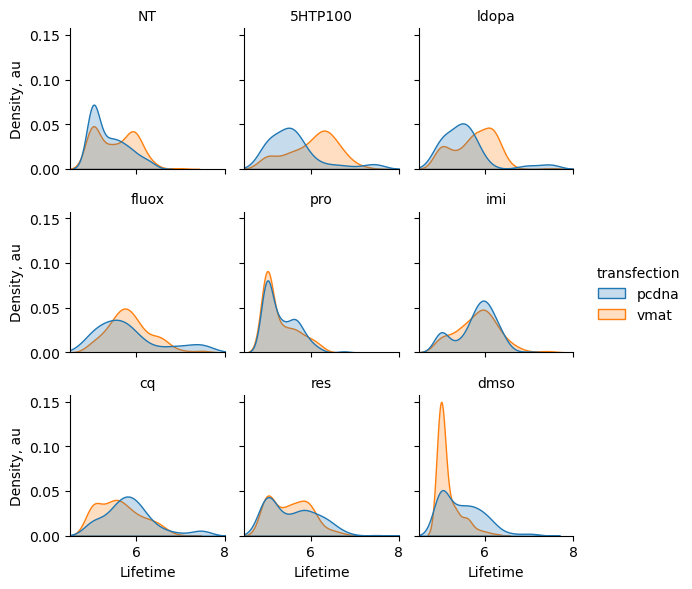

c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


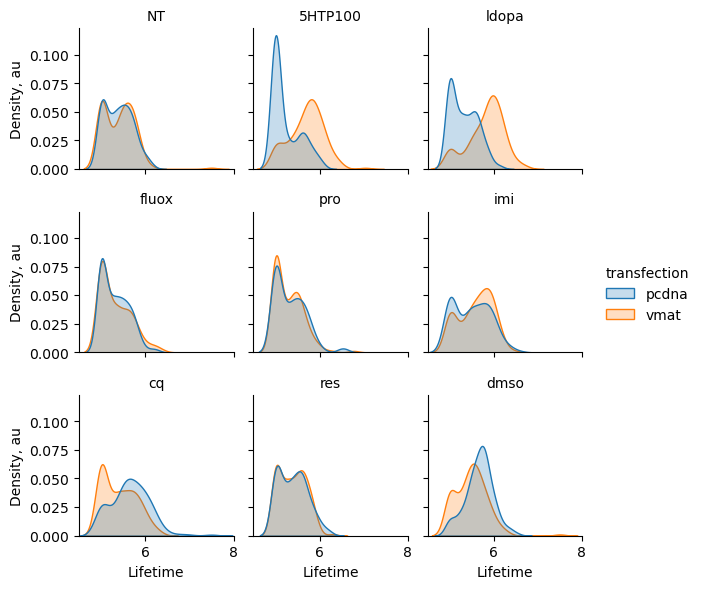

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for two different cell types
sampled_data_1 = sampled_data[sampled_data['cells'] == 'cl1']
sampled_data_2 = sampled_data[sampled_data['cells'] == 'cl2']

# Define the desired order of 'treatment' columns
treatment_order = ['NT', '5HTP100', 'ldopa','fluox','pro','imi','cq','res','dmso']  # Adjust based on your actual treatments

# Check if there's data in the filtered datasets
if not sampled_data_1.empty:
    # Plot for the first subset (e.g., CellType1)
    h1 = sns.displot(
        sampled_data_1, hue="transfection", x="predicted_pH_values", col="treatment",
        kind="kde", height=2, aspect=1, fill=True, col_wrap=3,col_order=treatment_order  # Specify the order of the 'treatment' columns
    )
    # Set axis labels and titles for the first plot
    h1.set_axis_labels("Lifetime", "Density, au")
    h1.set_titles("{col_name}")
    h1.set(xlim=(4.5, 8))
    #plt.suptitle("Density of Lifetime by Transfection and Treatment for CellType1", fontsize=16)
    plt.show()
else:
    print("No data available for CellType1")

# Check if there's data in the second filtered dataset
if not sampled_data_2.empty:
    # Plot for the second subset (e.g., CellType2)
    h2 = sns.displot(
        sampled_data_2, hue="transfection", x="predicted_pH_values", col="treatment",
        kind="kde", height=2, aspect=1, fill=True, col_wrap=3,col_order=treatment_order  # Specify the order of the 'treatment' columns
    )
    # Set axis labels and titles for the second plot
    h2.set_axis_labels("Lifetime", "Density, au")
    h2.set_titles("{col_name}")
    h2.set(xlim=(4.5, 8))
    #plt.suptitle("Density of Lifetime by Transfection and Treatment for CellType2", fontsize=16)
    plt.show()
else:
    print("No data available for CellType2")


In [6]:

# Function to calculate percentage of data in each range
def calculate_percentage_in_ranges(data, tau_col, ranges, group_cols):
    """
    Calculate the percentage of data points that fall within specified ranges.
    
    Args:
    - data: DataFrame containing the data.
    - tau_col: The column that contains the 'mean_tau' values.
    - ranges: List of tuples with ranges (e.g., [(800, 1000), (1100, 1200), ...]).
    - group_cols: The columns to group by (e.g., ['cells', 'transfection', 'treatment']).
    
    Returns:
    - DataFrame with the percentage of data points in each range for each group.
    """
    total_counts = data.groupby(group_cols)[tau_col].count().reset_index(name='total_count')

    results = []

    for range_name, (low, high) in ranges.items():
        # Filter data within the range
        in_range = data[(data[tau_col] >= low) & (data[tau_col] <= high)]
        
        # Count the number of data points in this range
        range_counts = in_range.groupby(group_cols)[tau_col].count().reset_index(name=f'{range_name}_count')
        
        # Merge with the total counts
        merged = pd.merge(total_counts, range_counts, on=group_cols, how='left')
        
        # Calculate the percentage
        merged[f'{range_name}_percentage'] = (merged[f'{range_name}_count'] / merged['total_count']) * 100
        
        # Append the results
        results.append(merged[[*group_cols, f'{range_name}_percentage']])

    # Merge all range results together
    final_result = results[0]
    for result in results[1:]:
        final_result = pd.merge(final_result, result, on=group_cols, how='left')

    return final_result

# Define the ranges
range1_50_55 = (800, 1000)
range2_60 = (1100, 1200)
range3_65 = (1200, 1400)
range4_70_75 = (1300, 1800)

# Define the ranges with names
ranges = {
    'range1_50_55': range1_50_55,
    'range2_60': range2_60,
    'range3_65': range3_65,
    'range4_70_75': range4_70_75
}

# Group by 'cells', 'transfection', and 'treatment'
group_cols = ['cells', 'transfection', 'treatment']

# Calculate the percentages for each range
percentage_results = calculate_percentage_in_ranges(df, 'mean_tau', ranges, group_cols)

# Display the result
print(percentage_results)


   cells transfection treatment  range1_50_55_percentage  \
0     c2         vmat   5HTP100                20.754717   
1    cl1        pcdna   5HTP100                58.994413   
2    cl1        pcdna        NT                76.985040   
3    cl1        pcdna        cq                31.016507   
4    cl1        pcdna      dmso                56.719368   
5    cl1        pcdna     fluox                45.759717   
6    cl1        pcdna       imi                23.877327   
7    cl1        pcdna     ldopa                66.702703   
8    cl1        pcdna        nt                16.015625   
9    cl1        pcdna       pro                82.152975   
10   cl1        pcdna      prop                64.539007   
11   cl1        pcdna       res                49.704142   
12   cl1         vmat   5HTP100                21.455939   
13   cl1         vmat      5htp                 0.800000   
14   cl1         vmat        NT                41.744186   
15   cl1         vmat        cq         

C:\Users\med\AppData\Local\Temp\ipykernel_6188\1549883887.py:18: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats = data.groupby(group_cols + ['binned_tau']).agg(
C:\Users\med\AppData\Local\Temp\ipykernel_6188\1549883887.py:18: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats = data.groupby(group_cols + ['binned_tau']).agg(
C:\Users\med\AppData\Local\Temp\ipykernel_6188\1549883887.py:18: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To compute the same result, you may do `(df - df.mean()).abs().mean()`.
  stats = data.groupby(group_cols + ['binned_tau']).agg(
C:\Users\med\AppData\Local\Temp\ipykernel_6188\1549883887.py:18: FutureWarning: The 'mad' method is deprecated and will be removed in a future version. To co

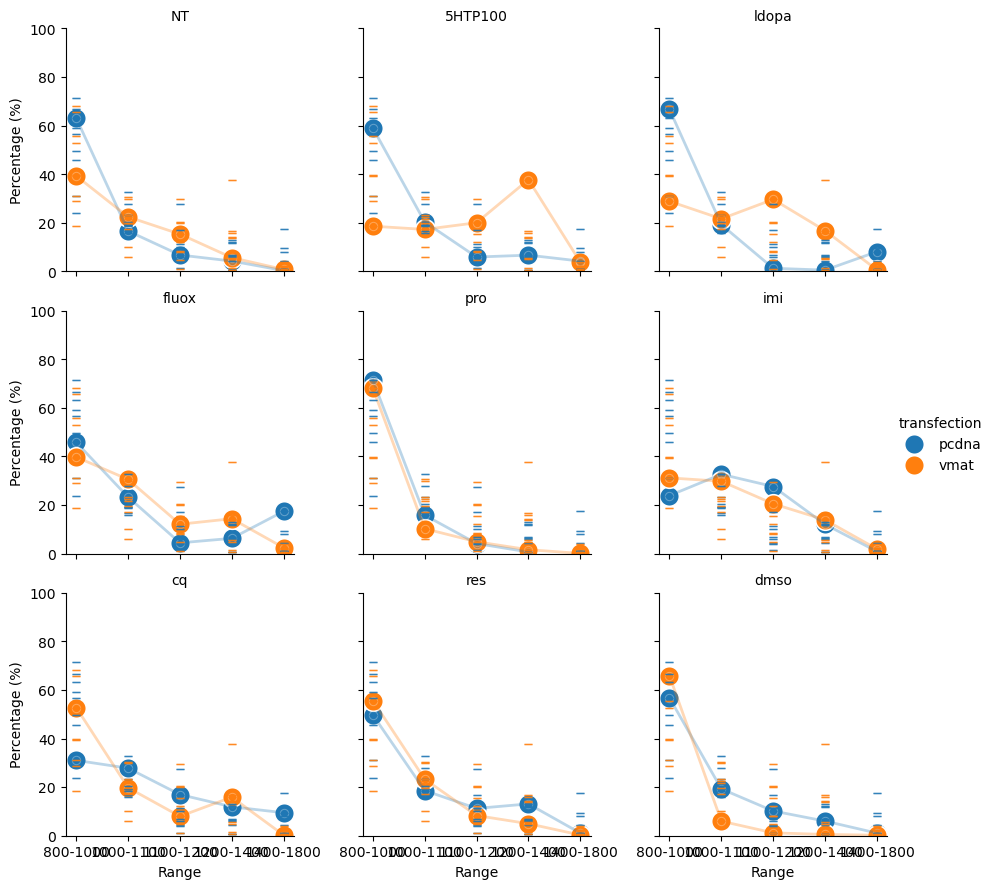

c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


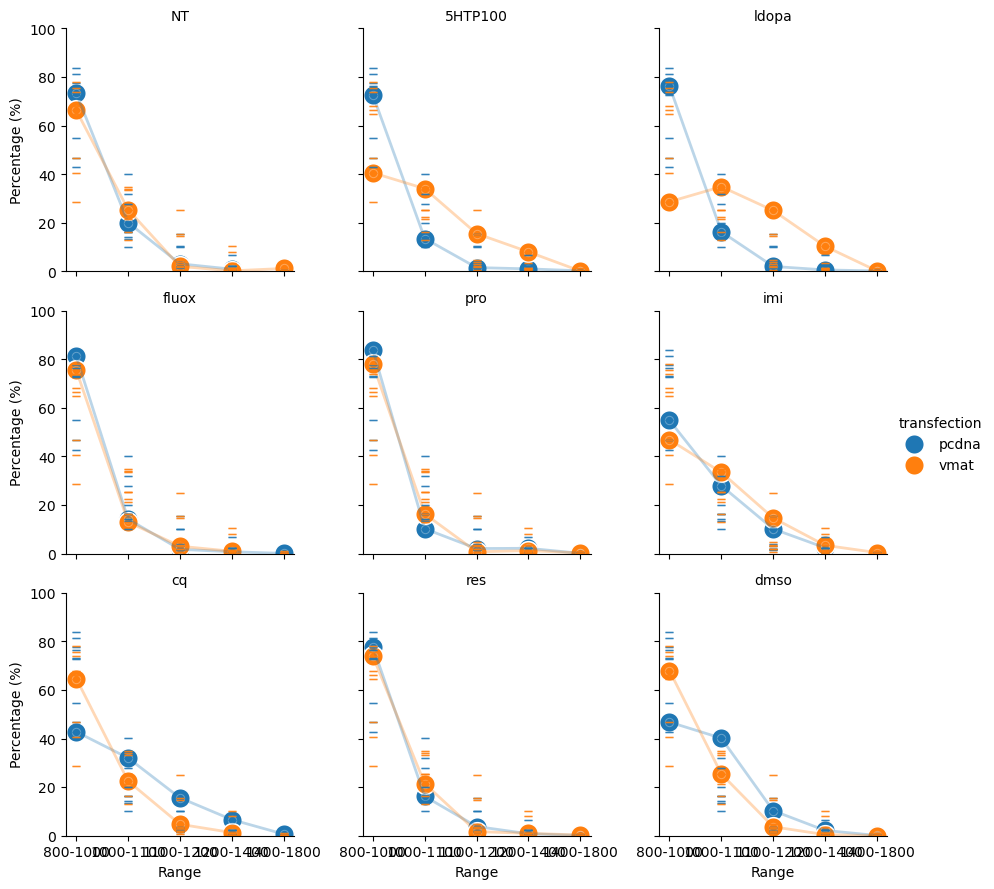

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom ranges for binning
bins = [800, 1000, 1100, 1200, 1400, 1800]
bin_labels = ['800-1000', '1000-1100', '1100-1200', '1200-1400', '1400-1800']

# Bin the data into the custom ranges
df2['binned_tau'] = pd.cut(df2['mean_tau'], bins=bins, labels=bin_labels)

# Define the desired order of 'treatment' columns
treatment_order = ['NT', '5HTP100', 'ldopa', 'fluox', 'pro', 'imi', 'cq', 'res', 'dmso']

# Function to calculate the median percentage and deviation from the median for each bin
def calculate_bin_stats(data, group_cols):
    # Group by the relevant columns and calculate median and deviation for each group
    stats = data.groupby(group_cols + ['binned_tau']).agg(
        percentage_median=('percentage', 'median'),         # Median percentage for each bin
        percentage_deviation=('percentage', 'mad')          # Median Absolute Deviation (MAD) for spread
    ).reset_index()
    return stats

# Calculate the bin statistics (median and deviation) for each combination of cells, transfection, and treatment
stats_data = calculate_bin_stats(df2, ['cells', 'transfection', 'treatment'])

# Filter for two different cell types
sampled_stats_1 = stats_data[stats_data['cells'] == 'cl1']
sampled_stats_2 = stats_data[stats_data['cells'] == 'cl2']

# Plotting function for scatter plots with lines and error bars
def plot_scatter_with_lines_and_errorbars(data, cell_type, treatment_order):
    # Check if there's data for the given cell type
    if not data.empty:
        # Create a FacetGrid for scatter plots
        g = sns.FacetGrid(data, col="treatment", hue="transfection", col_wrap=3, col_order=treatment_order, height=3, aspect=1)
        
        # Map line plot (median percentages) with scatter points
        g.map_dataframe(sns.lineplot, x="binned_tau", y="percentage_median", marker="o", linewidth=2, alpha=0.3)  # Line more transparent
        
        # Add larger scatter points
        g.map_dataframe(sns.scatterplot, x="binned_tau", y="percentage_median", s=200, alpha=1)  # Bigger points
        
        # Add error bars for deviation from the median (Median Absolute Deviation)
        for ax in g.axes.flatten():
            for transfection in data['transfection'].unique():
                subdata = data[data['transfection'] == transfection]
                ax.errorbar(
                    subdata['binned_tau'], subdata['percentage_median'],
                    yerr=subdata['percentage_deviation'], fmt='none', capsize=3, alpha=0.7, 
                    color=sns.color_palette()[list(data['transfection'].unique()).index(transfection)]  # Match the line color
                )

        # Customize plot appearance: set y-axis range from 0 to 100
        g.set_axis_labels("Range", "Percentage (%)")
        g.set_titles("{col_name}")
        g.set(ylim=(0, 100))  # Set y-axis from 0 to 100
        g.add_legend()
        plt.show()
    else:
        print(f"No data available for {cell_type}")

# Plot for CellType1
plot_scatter_with_lines_and_errorbars(sampled_stats_1, "CellType1", treatment_order)

# Plot for CellType2
plot_scatter_with_lines_and_errorbars(sampled_stats_2, "CellType2", treatment_order)





c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


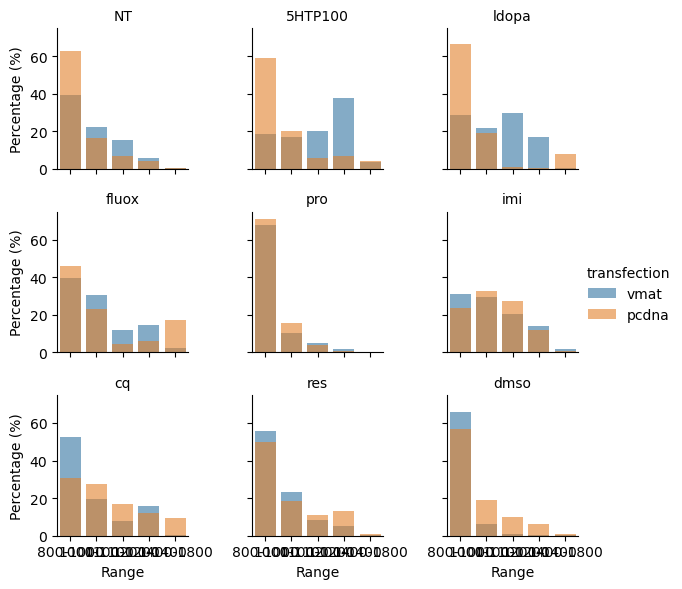

c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


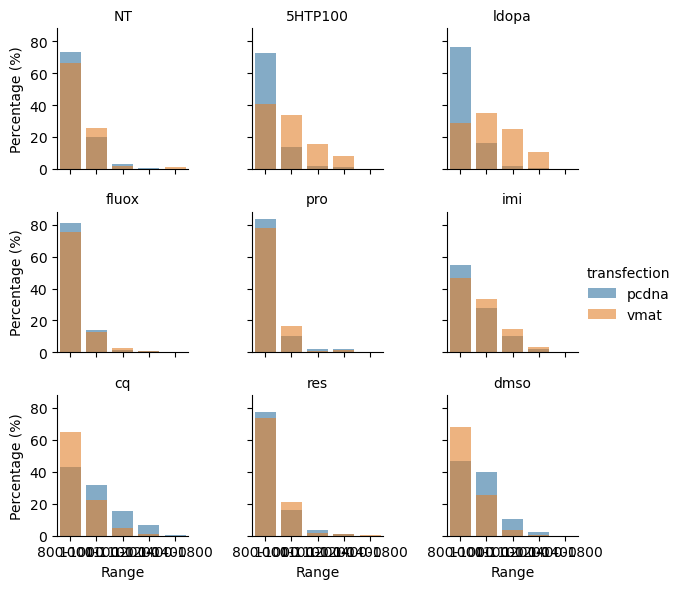

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom ranges for binning
bins = [800, 1000, 1100, 1200, 1400, 1800]
bin_labels = ['800-1000', '1000-1100', '1100-1200', '1200-1400', '1400-1800']

# Bin the data into the custom ranges
df2['binned_tau'] = pd.cut(df2['mean_tau'], bins=bins, labels=bin_labels)

# Define the desired order of 'treatment' columns
treatment_order = ['NT', '5HTP100', 'ldopa', 'fluox', 'pro', 'imi', 'cq', 'res', 'dmso']

# Function to calculate the percentage of data points in each bin
def calculate_bin_percentage(data, group_cols):
    total_count = data.groupby(group_cols)['mean_tau'].transform('count')
    bin_count = data.groupby(group_cols + ['binned_tau'])['mean_tau'].transform('count')
    data['percentage'] = (bin_count / total_count) * 100
    return data

# Group by 'cells', 'transfection', and 'treatment', and calculate the percentage of points in each bin
df2 = calculate_bin_percentage(df2, ['cells', 'transfection', 'treatment'])

# Filter for two different cell types
sampled_data_1 = df2[df2['cells'] == 'cl1']
sampled_data_2 = df2[df2['cells'] == 'cl2']

# Check if there's data in the filtered datasets for CellType1
if not sampled_data_1.empty:
    # Create bar plots showing the percentage for the first subset (CellType1) with transfections overlaid
    g1 = sns.catplot(
        data=sampled_data_1, x="binned_tau", y="percentage", col="treatment", hue="transfection",
        kind="bar", height=2, aspect=1, col_wrap=3, col_order=treatment_order, dodge=False, alpha=0.6
    )
    # Set axis labels and titles for the first plot
    g1.set_axis_labels("Range", "Percentage (%)")
    g1.set_titles("{col_name}")
    plt.show()
else:
    print("No data available for CellType1")

# Check if there's data in the filtered datasets for CellType2
if not sampled_data_2.empty:
    # Create bar plots showing the percentage for the second subset (CellType2) with transfections overlaid
    g2 = sns.catplot(
        data=sampled_data_2, x="binned_tau", y="percentage", col="treatment", hue="transfection",
        kind="bar", height=2, aspect=1, col_wrap=3, col_order=treatment_order, dodge=False, alpha=0.6
    )
    # Set axis labels and titles for the second plot
    g2.set_axis_labels("Range", "Percentage (%)")
    g2.set_titles("{col_name}")
    plt.show()
else:
    print("No data available for CellType2")


In [40]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def bootstrap_confidence_intervals(data, n_iterations=1000, sample_size=None, statistic='mean'):
    """
    Bootstrap confidence intervals for a given statistic (e.g., mean, std, or percentile).
    
    Args:
    - data: Array or list of data to bootstrap.
    - n_iterations: Number of bootstrap iterations.
    - sample_size: Size of each sample (default is the length of the original data).
    - statistic: Statistic to compute ('mean', 'std', 'percentile_5', 'percentile_95', etc.).
    
    Returns:
    - A list of bootstrapped statistics.
    """
    if sample_size is None:
        sample_size = len(data)
        
    stats = []
    
    for _ in range(n_iterations):
        sample = np.random.choice(data, size=sample_size, replace=True)
        
        if statistic == 'mean':
            stats.append(np.mean(sample))
        elif statistic == 'std':
            stats.append(np.std(sample))
        elif 'percentile' in statistic:
            percentile = int(statistic.split('_')[1])
            stats.append(np.percentile(sample, percentile))
        else:
            raise ValueError("Statistic not supported.")
    
    return stats

# Example of using bootstrapping to compare treatments vs DMSO
def compare_distributions_bootstrap(data, treatment_col='treatment', cell_col='cells', target_col='mean_tau', transfection_col='transfection'):
    """
    Perform bootstrapping to analyze differences in distributions (not just mean) between treatments and DMSO.
    
    Args:
    - data: DataFrame containing the dataset.
    - treatment_col: Column name for treatment.
    - cell_col: Column name for cell types.
    - transfection_col: Column name for transfection groups.
    - target_col: Column name for the data of interest (e.g., mean_tau).
    
    Returns:
    - A DataFrame with bootstrapped confidence intervals for different statistics.
    """
    results = []

    # Get the unique cell types
    cell_types = data[cell_col].unique()

    for cell in cell_types:
        # Filter the data by cell type
        cell_data = data[data[cell_col] == cell]
        
        # Get the DMSO group
        dmso_group = cell_data[cell_data[treatment_col] == 'dmso'][target_col]

        # Get the unique treatments (excluding DMSO)
        treatments = cell_data[cell_data[treatment_col] != 'dmso'][treatment_col].unique()

        for treatment in treatments:
            treatment_group = cell_data[cell_data[treatment_col] == treatment][target_col]

            # Bootstrap confidence intervals for mean, std, and percentiles
            treatment_bootstrap_mean = bootstrap_confidence_intervals(treatment_group, statistic='mean')
            treatment_bootstrap_std = bootstrap_confidence_intervals(treatment_group, statistic='std')
            treatment_bootstrap_percentile_5 = bootstrap_confidence_intervals(treatment_group, statistic='percentile_5')
            treatment_bootstrap_percentile_95 = bootstrap_confidence_intervals(treatment_group, statistic='percentile_95')
            
            dmso_bootstrap_mean = bootstrap_confidence_intervals(dmso_group, statistic='mean')
            dmso_bootstrap_std = bootstrap_confidence_intervals(dmso_group, statistic='std')
            dmso_bootstrap_percentile_5 = bootstrap_confidence_intervals(dmso_group, statistic='percentile_5')
            dmso_bootstrap_percentile_95 = bootstrap_confidence_intervals(dmso_group, statistic='percentile_95')

            results.append({
                'cell_type': cell,
                'treatment': treatment,
                'treatment_bootstrap_mean': np.mean(treatment_bootstrap_mean),
                'treatment_bootstrap_std': np.mean(treatment_bootstrap_std),
                'treatment_percentile_5': np.mean(treatment_bootstrap_percentile_5),
                'treatment_percentile_95': np.mean(treatment_bootstrap_percentile_95),
                'dmso_bootstrap_mean': np.mean(dmso_bootstrap_mean),
                'dmso_bootstrap_std': np.mean(dmso_bootstrap_std),
                'dmso_percentile_5': np.mean(dmso_bootstrap_percentile_5),
                'dmso_percentile_95': np.mean(dmso_bootstrap_percentile_95)
            })
    
    return pd.DataFrame(results)

# Run the bootstrapping comparison
bootstrap_results = compare_distributions_bootstrap(sampled_data)

# Display the results
print(bootstrap_results)


c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
c:\Users\med\mambaforge\envs\napari-flim-phasor-env\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret 

IndexError: cannot do a non-empty take from an empty axes.

In [79]:
from scipy.stats import ks_2samp

def ks_test_distributions(data, treatment_col='treatment', cell_col='cells', target_col='mean_tau'):
    """
    Perform the Kolmogorov-Smirnov test to compare distribution shapes between treatments and DMSO.
    
    Args:
    - data: DataFrame containing the dataset.
    
    Returns:
    - A DataFrame with KS test results for each treatment vs DMSO.
    """
    results = []
    
    cell_types = data[cell_col].unique()

    for cell in cell_types:
        cell_data = data[data[cell_col] == cell]
        dmso_group = cell_data[cell_data[treatment_col] == 'dmso'][target_col]
        treatments = cell_data[cell_data[treatment_col] != 'dmso'][treatment_col].unique()

        for treatment in treatments:
            treatment_group = cell_data[cell_data[treatment_col] == treatment][target_col]
            ks_stat, p_value = ks_2samp(treatment_group, dmso_group)
            results.append({
                'cell_type': cell,
                'treatment': treatment,
                'ks_stat': ks_stat,
                'p_value': p_value
            })
    
    return pd.DataFrame(results)

# Run the KS test
ks_test_results = ks_test_distributions(sampled_data)

# Display KS test results
print(ks_test_results)

# Filter for significant p-values (e.g., p-value < 0.05)
significant_ks_results = ks_test_results[ks_test_results['p_value'] < 0.05]
print("Significant KS test results:")
print(significant_ks_results)


   cell_type  treatment  ks_stat       p_value
0        cl1       5htp    0.815  4.783211e-67
1        cl1         cq    0.305  1.294088e-08
2        cl1      fluox    0.290  8.114130e-08
3        cl1        imi    0.265  1.392105e-06
4        cl1         nt    0.390  5.867302e-14
5        cl1       prop    0.120  1.122836e-01
6        cl1  propoeres    0.560  3.190552e-29
7        cl1        res    0.170  6.094418e-03
8        cl2         cq    0.195  9.668691e-04
9        cl2      fluox    0.420  3.432079e-16
10       cl2        imi    0.235  2.960783e-05
11       cl2       prop    0.505  6.514965e-16
12       cl2        res    0.310  6.865582e-09
13       cl2        pro    0.300  9.908152e-06
Significant KS test results:
   cell_type  treatment  ks_stat       p_value
0        cl1       5htp    0.815  4.783211e-67
1        cl1         cq    0.305  1.294088e-08
2        cl1      fluox    0.290  8.114130e-08
3        cl1        imi    0.265  1.392105e-06
4        cl1         nt    0.39

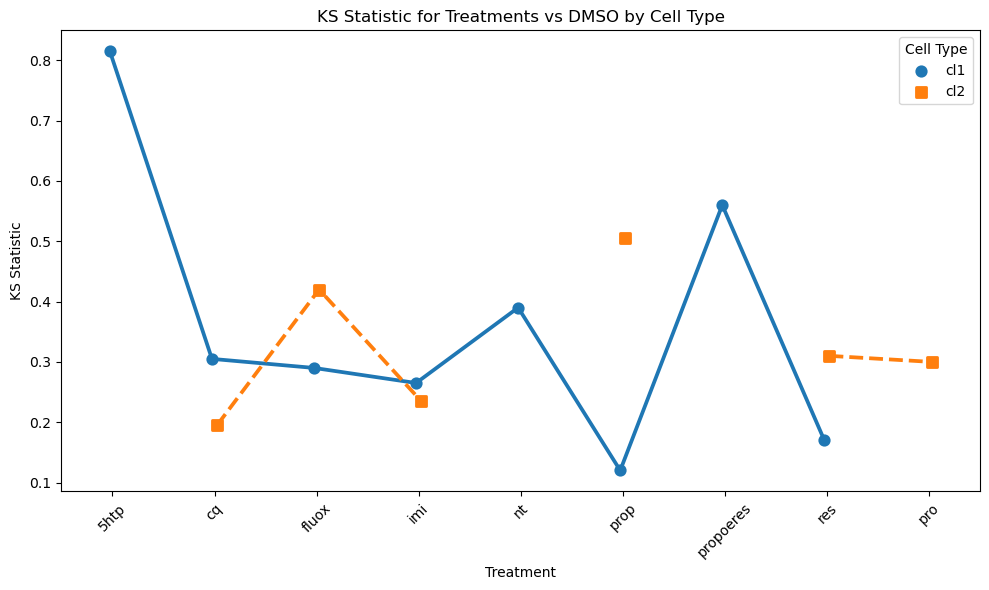

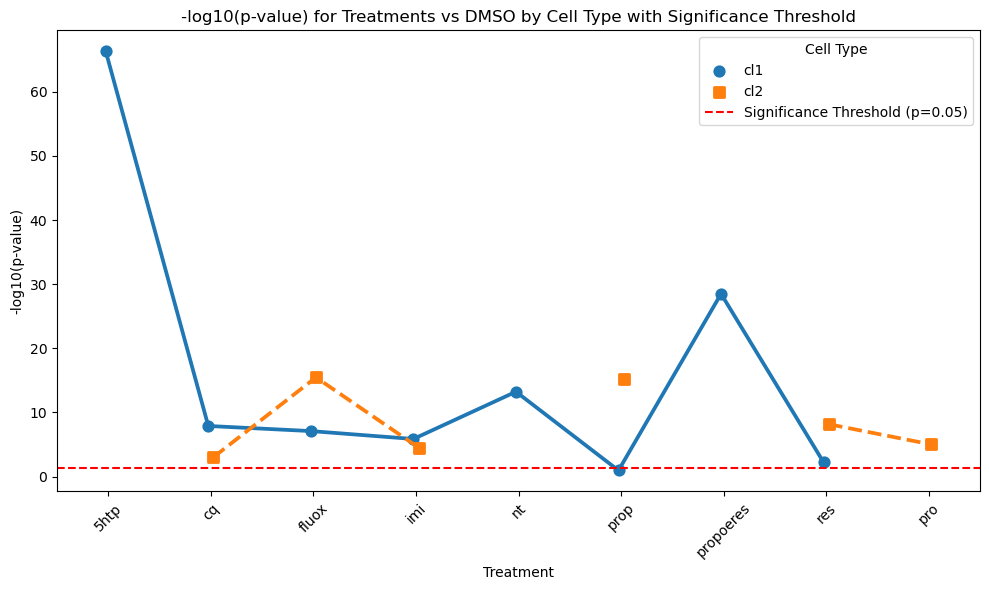

In [95]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Convert p-values to -log10 for better visualization (optional)
ks_test_results['log_p_value'] = -np.log10(ks_test_results['p_value'])

# Create a point plot for KS statistic
plt.figure(figsize=(10, 6))
sns.pointplot(data=ks_test_results, x='treatment', y='ks_stat', hue='cell_type', dodge=True, markers=['o', 's'], linestyles=['-', '--'])
plt.title('KS Statistic for Treatments vs DMSO by Cell Type')
plt.ylabel('KS Statistic')
plt.xlabel('Treatment')
plt.xticks(rotation=45)
plt.legend(title='Cell Type')
plt.tight_layout()
plt.show()

# Create a point plot for log(p-value) with a significance threshold
plt.figure(figsize=(10, 6))
sns.pointplot(data=ks_test_results, x='treatment', y='log_p_value', hue='cell_type', dodge=True, markers=['o', 's'], linestyles=['-', '--'])

# Add a horizontal line for the significance threshold at -log10(0.05)
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='Significance Threshold (p=0.05)')

# Plot customization
plt.title('-log10(p-value) for Treatments vs DMSO by Cell Type with Significance Threshold')
plt.ylabel('-log10(p-value)')
plt.xlabel('Treatment')
plt.xticks(rotation=45)
plt.legend(title='Cell Type')
plt.tight_layout()
plt.show()
